In [1]:
import networkx as nx
import dwave_networkx as dnx
import minorminer
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import random
from dwave.system import DWaveSampler, FixedEmbeddingComposite
import sys
from minorminer import find_embedding
from dwave.embedding.zephyr import find_biclique_embedding
from model.rbm.rbm_two_partite import RBM_TwoPartite
import torch
import torch
from hydra.utils import instantiate
from hydra import initialize, compose
import hydra
from omegaconf import OmegaConf
import os
from scripts.run import setup_model, load_model_instance
from utils.rbm_plots import rbm_to_networkx, plot_pruning_analysis
import dwave_networkx as dnx
import dwave.inspector
from typing import Tuple, Dict, List, Optional
import time
import numpy as np
import wandb


[23:22:21.461] INFO   CaloQuVAE                                         Loading configuration.


In [ ]:
def rbm_to_logical_ising(
    rbm, 
    beta: float = 1.0,
    bias_limit: float = 6.0,   
    coupler_limit: float = 1.0 # 
) -> Tuple[Dict[int, float], Dict[Tuple[int, int], float], int, int]:

    num_visible = rbm.params["weight_matrix"].shape[0]
    num_hidden = rbm.params["weight_matrix"].shape[1]

    # Clone parameters to avoid modifying the original RBM
    W = rbm.params["weight_matrix"].clone()
    vb = rbm.params["vbias"].clone()
    hb = rbm.params["hbias"].clone()
    
    
    # J_ij = W_ij / 4
    dwave_J_tensor = -W / 4.0 / beta
    
    # h_i (visible) = v_i/2 + sum_j(W_ij/4)
    s_v = -torch.sum(W, dim=1) / 4.0 / beta
    dwave_h_visible = -vb / 2.0 / beta + s_v

    # h_j (hidden) = h_j/2 + sum_i(W_ij/4)
    s_h = -torch.sum(W, dim=0) / 4.0 / beta
    dwave_h_hidden = -hb / 2.0 / beta + s_h
    
    dwave_h_visible = torch.clamp(dwave_h_visible, min=-bias_limit, max=bias_limit)
    dwave_h_hidden = torch.clamp(dwave_h_hidden, min=-bias_limit, max=bias_limit)
    
    dwave_J_tensor = torch.clamp(dwave_J_tensor, min=-coupler_limit, max=coupler_limit)
    
    all_biases_np = torch.cat([dwave_h_visible, dwave_h_hidden]).detach().cpu().numpy()
    dwave_J_tensor_np = dwave_J_tensor.detach().cpu().numpy()

    h = {}
    for i in range(num_visible + num_hidden):
        h[i] = float(all_biases_np[i])

    J = {}
    for i in range(num_visible):
        for j in range(num_hidden):
            val = float(dwave_J_tensor_np[i, j])
            J[(i, j + num_visible)] = val
                
    return h, J, num_visible, num_hidden
def get_sampler_and_biclique_embedding(
    num_visible: int, 
    num_hidden: int, 
    solver_name: str
) -> Tuple[object, Dict[int, List[int]]]:
    
    print(f"--- Finding Zephyr Embedding for K_{num_visible},{num_hidden} ---")

    try:
        raw_sampler = DWaveSampler(solver=solver_name)
    except Exception as e:
        print(f"Error initializing sampler: {e}")
        return None, None

    # 1. Get the hardware graph
    # This ensures we don't use broken qubits specific to this chip
    working_graph = raw_sampler.to_networkx_graph()
    
    # 2. Generate the embedding
    # Note: We pass num_visible (int) and num_hidden (int).
    # The docs say: "If both a and b are integers, the right shore will be labelled [a, a+b-1]."
    # This means the keys will automatically be 0..n_vis-1 and n_vis..total-1.
    try:
        left_dict, right_dict = find_biclique_embedding(
            num_visible, 
            num_hidden, 
            target_graph=working_graph
        )
    except ValueError as e:
        print(f"Error: RBM is too large for this QPU or topology mismatch. {e}")
        return raw_sampler, None

    # 3. Merge the dictionaries
    # We don't need to wrap values in lists; find_biclique_embedding 
    # already returns chains (iterables) as values.
    embedding = {**left_dict, **right_dict}
    
    # Convert all chains to lists just to be safe (sometimes they are sets/tuples)
    for k, v in embedding.items():
        embedding[k] = list(v)

    print(f"Successfully created embedding for {len(embedding)} nodes.")
    return raw_sampler, embedding
    
def sample_logical_ising(
    qpu_sampler,
    h: Dict[int, float],
    J: Dict[Tuple[int, int], float],
    num_samples: int = 64,
    measure_time: bool = False,
    chain_strength: float = 1.5
) -> Tuple[object, Optional[float]]:
    """
    Calls the D-Wave sampler with a logical Ising problem.

    Args:
        qpu_sampler: A D-Wave sampler (e.g., EmbeddingComposite).
        h (dict): Logical linear biases.
        J (dict): Logical quadratic couplers.
        num_samples (int): Number of reads.
        measure_time (bool): If True, times the QPU call.

    Returns:
        tuple:
            - response (dimod.SampleSet): The raw D-Wave response.
            - sampling_time (float or None): QPU sampling time.
    """
    sampling_time = None
    if measure_time:
        start = time.perf_counter()
        response = qpu_sampler.sample_ising(h, J, num_reads=num_samples, answer_mode='raw', auto_scale=False, chain_break_fraction=True, chain_strength=chain_strength)
        sampling_time = time.perf_counter() - start
    else:
        response = qpu_sampler.sample_ising(h, J, num_reads=num_samples, answer_mode='raw', auto_scale=False, chain_break_fraction=True, chain_strength=chain_strength)
    print(f"Fraction of broken chains: {np.mean(response.record.chain_break_fraction)}")

    return response, sampling_time

def process_rbm_samples(
    response, # dimod.SampleSet object
    num_visible: int,
    num_hidden: int,
    device: torch.device
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    Converts raw D-Wave spin samples {-1, 1} into binary {0, 1} RBM
    samples, splits them, and moves them to the target device.

    Args:
        response (dimod.SampleSet): The raw output from the D-Wave sampler.
        num_visible (int): Number of visible nodes.
        num_hidden (int): Number of hidden nodes.
        device (torch.device): The torch device (e.g., 'cuda' or 'cpu')
                               to put the final tensors on.

    Returns:
        tuple:
            - visible_samples (torch.Tensor): Samples for visible nodes.
            - hidden_samples (torch.Tensor): Samples for hidden nodes.
    """
    total_nodes = num_visible + num_hidden
    num_samples = len(response.record.sample)

    # --- 5. Process Samples ---
    var_to_col_idx = {var: i for i, var in enumerate(response.variables)}
    
    try:
        ordered_cols = [var_to_col_idx[i] for i in range(total_nodes)]
    except KeyError as e:
        print(f"Error: A logical node index '{e.args[0]}' was missing from the D-Wave response variables.")
        print("This can happen if a node has 0 bias and 0 couplers (is disconnected).")
        # Handle this by creating a default (e.g., all 0) sample array
        visible_samples = torch.zeros((num_samples, num_visible), device=device, dtype=torch.float)
        hidden_samples = torch.zeros((num_samples, num_hidden), device=device, dtype=torch.float)
        return visible_samples, hidden_samples

    # Get all samples and re-order them
    dwave_spin_samples = response.record.sample[:, ordered_cols]
    
    # Convert from numpy array to torch tensor
    dwave_spin_samples_t = torch.tensor(dwave_spin_samples, dtype=torch.float, device=device)

    # --- 6. Convert spin samples {-1, 1} to binary {0, 1} ---
    _ZERO = torch.tensor(0., dtype=torch.float, device=device)
    _MINUS_ONE = torch.tensor(-1., dtype=torch.float, device=device)
    
    dwave_binary_samples = torch.where(
        dwave_spin_samples_t == _MINUS_ONE,
        _ZERO,
        dwave_spin_samples_t
    )

    # --- 7. Split into Visible and Hidden Partitions ---
    visible_samples = dwave_binary_samples[:, :num_visible]
    hidden_samples = dwave_binary_samples[:, num_visible:]
    
    return visible_samples, hidden_samples
def check_solver_health(sampler, load_threshold=50.0):
    """
    Checks if the D-Wave solver is online and if the queue is reasonable.
    """
    # 1. Force a metadata refresh (updates avg_load and status)
    # The client caches data, so we trigger a fetch
    sampler.solver.client.get_solvers(refresh=True)
    
    solver_id = sampler.solver.identity
    status = sampler.solver.online
    avg_load = sampler.solver.avg_load
    
    print(f"--- Solver Status: {solver_id} ---")
    print(f"  Status:   {status}") 
    print(f"  Avg Load: {avg_load:.2f} (jobs in queue)")

    print("  --> Solver looks good. Proceeding.")

In [3]:
sampler = DWaveSampler(solver='Advantage2_system1.8')
print(sampler.properties.keys())
print(sampler.properties["h_range"])
print(sampler.properties["j_range"])

[23:22:23.187] INFO   dwave.cloud.config.models                         Invalid solver JSON, parsing as string identity: 'Advantage2_system1.8'
[23:22:23.200] INFO   dwave.cloud.client.base                           Fetching definition of a solver with name='Advantage2_system1.8'
[23:22:23.404] INFO   dwave.cloud.client.base                           Received solver data for 1 solver(s).
[23:22:23.405] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(name='Advantage2_system1.8', graph_id='01f0cf09cb')


dict_keys(['num_qubits', 'qubits', 'couplers', 'h_range', 'j_range', 'supported_problem_types', 'parameters', 'anneal_offset_ranges', 'anneal_offset_step', 'anneal_offset_step_phi0', 'annealing_time_range', 'chip_id', 'default_annealing_time', 'default_programming_thermalization', 'default_readout_thermalization', 'extended_j_range', 'fast_anneal_time_range', 'h_gain_schedule_range', 'max_anneal_schedule_points', 'max_h_gain_schedule_points', 'num_reads_range', 'per_group_coupling_range', 'problem_run_duration_range', 'problem_timing_data', 'programming_thermalization_range', 'readout_thermalization_range', 'tags', 'topology', 'category', 'quota_conversion_rate'])
[-6.0, 6.0]
[-1.0, 1.0]


In [4]:
SOLVER_NAME = "Advantage2_system1.8" 
BETA = 1.0
NUM_SAMPLES = 64
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="config")
cfg=compose(config_name="config.yaml")
self = setup_model(cfg)


dummy_data = torch.zeros(1, cfg.rbm.latent_nodes_per_p).to(self.device)
CHECKPOINT_FILE = "/home/leozhu/CaloQuVAE/wandb-outputs/run_2025-11-09_19-06-22_RBM_TwoPartite/training_checkpoint.h5"
rbm = RBM_TwoPartite(cfg, data=dummy_data)

try:
    # Load the latest epoch (epoch=None)
    loaded_epoch = rbm.load_checkpoint(CHECKPOINT_FILE, epoch=None) 
    print(f"Successfully loaded checkpoint from epoch {loaded_epoch}.")
except Exception as e:
    print(f"Error loading checkpoint: {e}")

weights = rbm.params["weight_matrix"]
vbias = rbm.params["vbias"]
print(f"  Weight matrix shape: {weights.shape}")
print(f"  Visible bias mean: {vbias.mean().item():.4f}")


[23:22:23.751] INFO   data.dataManager                                  Loading ATLAS dataset: AtlasCustom1
[23:22:25.014] INFO   data.atlas                                        Using Linear Binning for Custom ATLAS Dataset
[23:22:25.167] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fc4704351c0>: 80000 events, 157 batches
[23:22:25.168] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fc470435010>: 10000 events, 10 batches
[23:22:25.170] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7fc470435250>: 10000 events, 10 batches
[23:22:25.170] INFO   model.modelCreator                                ::Creating Model
[23:22:25.228] INFO   model.rbm.zephyr                                  RBM is configured to be fully connected.
[23:22:25.230] INFO   model.rbm.rbm_fulltorch                           RBMTorc

Using conditional latent size in decoder


[23:22:26.645] INFO   scripts.run                                       CUDA available


cuda:5


[23:22:27.214] INFO   model.rbm.rbm_two_partite                         Initializing RBM parameters with std: 0.0001
[23:22:27.274] INFO   model.rbm.rbm_two_partite                         Loading parameters from epoch_1999...
[23:22:27.351] INFO   model.rbm.rbm_two_partite                         Loaded persistent chains.
[23:22:27.353] INFO   model.rbm.rbm_two_partite                         Restoring RNG states...


Successfully loaded checkpoint from epoch 1999.
  Weight matrix shape: torch.Size([76, 76])
  Visible bias mean: -0.6454


In [5]:
# Initialize connection ONCE
raw_sampler = DWaveSampler(solver=SOLVER_NAME)

# Get the graph ONCE (This is the slow part)
print("Fetching hardware graph...")
working_graph = raw_sampler.to_networkx_graph()

# Calculate Embedding ONCE
# (Only re-run this if you change the RBM size)
n_vis = rbm.params["weight_matrix"].shape[0]
n_hid = rbm.params["weight_matrix"].shape[1]

print(f"Calculating embedding for {n_vis} visible, {n_hid} hidden...")
left_dict, right_dict = find_biclique_embedding(
    n_vis, 
    n_hid, 
    target_graph=working_graph
)
embedding = {**left_dict, **right_dict}
for k, v in embedding.items():
    embedding[k] = list(v)
    
# Create the Composite ONCE

qpu_sampler = FixedEmbeddingComposite(raw_sampler, embedding)
print("Setup complete. Sampler is ready.")
# check_solver_health(raw_sampler)

[23:22:27.401] INFO   dwave.cloud.config.models                         Invalid solver JSON, parsing as string identity: 'Advantage2_system1.8'
[23:22:27.414] INFO   dwave.cloud.client.base                           Fetching definition of a solver with name='Advantage2_system1.8'
[23:22:27.435] INFO   dwave.cloud.client.base                           Received solver data for 1 solver(s).
[23:22:27.436] INFO   dwave.cloud.client.base                           Adding solver StructuredSolver(name='Advantage2_system1.8', graph_id='01f0cf09cb')


Fetching hardware graph...
Calculating embedding for 76 visible, 76 hidden...
Setup complete. Sampler is ready.


In [6]:
# --- 1. Get Logical Problem (Fast) ---
h_limit = raw_sampler.properties["h_range"][1]
j_limit = raw_sampler.properties["j_range"][1]
h_logical, J_logical, _, _ = rbm_to_logical_ising(rbm, beta=BETA, bias_limit=h_limit, coupler_limit=j_limit)

# --- 2. Sample (Fast) ---
# We skip the embedding calculation and graph download here
max_j = max([abs(val) for val in J_logical.values()]) if J_logical else 0.0
max_h = max([abs(val) for val in h_logical.values()]) if h_logical else 0.0
chain_strength = max(max_j, max_h) * 1.5 

print(f"Sampling {NUM_SAMPLES} reads...")
response, qpu_time = sample_logical_ising(
    qpu_sampler, # Uses the cached sampler from Cell 1
    h_logical,
    J_logical,
    num_samples=NUM_SAMPLES,
    measure_time=True,
    chain_strength=chain_strength
)

Sampling 64 reads...


SolverFailureError: Quadratic coefficients out of extended_j_range.

In [ ]:
# --- 1. Get Logical Problem ---
print("1. Creating logical Ising problem from RBM...")
h_logical, J_logical, n_vis, n_hid = rbm_to_logical_ising(
    rbm, 
    beta=BETA
)

# --- 2. Find Custom Embedding ---
print("2. Finding custom biclique embedding...")
raw_sampler, embedding = get_sampler_and_biclique_embedding(
    n_vis, 
    n_hid,
    SOLVER_NAME
)

if embedding is None:
    print("Failed to find embedding. Exiting.")
    # exit()

print(embedding)

# --- 3. Create the Custom-Embedded Sampler ---
print("3. Creating composite sampler with custom embedding...")
# We pass our pre-calculated embedding to EmbeddingComposite.
# It will use this embedding instead of running minorminer.
qpu_sampler = FixedEmbeddingComposite(raw_sampler, embedding)

# --- 4. Call the Sampler ---
max_j = max([abs(val) for val in J_logical.values()]) if J_logical else 0.0
max_h = max([abs(val) for val in h_logical.values()]) if h_logical else 0.0
chain_strength = max(max_j, max_h) * 1.5 

print(f"Using chain strength: {chain_strength}")
print(f"4. Sampling {NUM_SAMPLES} reads from QPU...")
response, qpu_time = sample_logical_ising(
    qpu_sampler,
    h_logical,
    J_logical,
    num_samples=NUM_SAMPLES,
    measure_time=True,
    chain_strength=chain_strength
)
print(f"QPU sampling time: {qpu_time:.4f} seconds")

In [7]:
visible_samples, hidden_samples = process_rbm_samples(
    response,
    n_vis,
    n_hid,
    rbm.device
)

print("\n--- Done ---")
print(f"Visible samples shape: {visible_samples.shape}")
print(f"Hidden samples shape: {hidden_samples.shape}")

NameError: name 'response' is not defined

In [12]:
def joint_energy(rbm, v, h):
    """
    Computes the Joint Hamiltonian Energy E(v,h) = -vWh - bv - ch.
    Calculates the specific energy of the configuration, not Free Energy.
    """
    # 1. Interaction term: sum( (v @ W) * h )
    # v @ W -> [batch, n_hidden], then element-wise multiply by h
    interaction = (v @ rbm.params["weight_matrix"]) * h 
    interaction_sum = interaction.sum(dim=1)
    
    # 2. Bias terms
    v_bias = v @ rbm.params["vbias"]
    h_bias = h @ rbm.params["hbias"]
    
    # 3. Total Energy (negative sum)
    return -interaction_sum - v_bias - h_bias

def find_beta(
    rbm, 
    qpu_sampler,
    num_reads: int = 128,
    beta_init: float = 1.0,
    lr: float = 0.1,
    num_epochs: int = 15,
    adaptive: bool = False,
    lr_cap: float = 0.5
):
    beta = beta_init
    beta_history = []
    
    # History tracking
    rbm_energy_history = []
    qpu_energy_history = []
    
    # --- 1. Get RBM Baseline Samples ---
    print("Sampling baseline from RBM chains...")
    
    # Run a few Gibbs steps to ensure chains are mixed
    rbm.sample_state(beta=1.0)
        
    # Extract samples directly from the class's persistent chains
    # We slice [:num_reads] to ensure we compare equal batch sizes
    rbm_v = rbm.chains["v"][:num_reads]
    rbm_h = rbm.chains["h"][:num_reads]
    
    # Calculate Mean Energy of RBM samples (Target Energy)
    with torch.no_grad():
        e_rbm_batch = joint_energy(rbm, rbm_v, rbm_h)
        mean_rbm_energy = e_rbm_batch.mean().item()
    
    print(f"Target (RBM) Mean Energy: {mean_rbm_energy:.4f}")

# --- 2. Optimization Loop ---
    for epoch in range(num_epochs):
        
        # A. Scale & Embed
        scaled_h, scaled_J, n_vis, n_hid = rbm_to_logical_ising(rbm, beta=beta)
        
        # Heuristic chain strength
        max_abs_j = max([abs(val) for val in scaled_J.values()])
        max_force = max(max_abs_j, 0)
        chain_str = max(0.5, max_force * 4.0)
        
        print(f"  Chain Strength set to: {chain_str:.2f} (Max Force: {max_force:.2f})")        
        # B. Sample
        response, _ = sample_logical_ising(
            qpu_sampler, 
            scaled_h, 
            scaled_J, 
            num_samples=num_reads, 
            chain_strength=chain_str
        )
        

        # C. Process
        dwave_v, dwave_h = process_rbm_samples(
            response, 
            num_visible=n_vis, 
            num_hidden=n_hid, 
            device=rbm.device
        )
        
        # D. Energy & Variance
        with torch.no_grad():
            e_dwave_batch = joint_energy(rbm, dwave_v, dwave_h)
            mean_dwave_energy = e_dwave_batch.mean().item()
            # Calculate Variance for Adaptive LR
            var_dwave_energy = torch.var(e_dwave_batch).item()
            
        # E. Adaptive Learning Rate Logic
        if adaptive:
            # Avoid division by zero
            safe_var = max(1e-6, var_dwave_energy)
            
            # Original Formula: max(lr_init, beta^2 / Variance)
            calc_lr = (beta**2) / safe_var
            
            # Apply Cap to prevent explosions
            current_lr = min(lr_cap, max(lr, calc_lr))
        else:
            current_lr = lr

        # F. Update Beta
        # Diff > 0 means QPU is Hot -> Beta Decreases
        diff = mean_dwave_energy - mean_rbm_energy
        beta -= current_lr * diff        
        # Clamp Beta to prevent it from going negative or too close to zero
        beta = max(1e-2, beta)
        # Logging
        beta_history.append(beta)
        rbm_energy_history.append(mean_rbm_energy)
        qpu_energy_history.append(mean_dwave_energy)
        
        print(f"Epoch {epoch}: Beta={beta:.4f} | QPU_E={mean_dwave_energy:.2f} vs RBM_E={mean_rbm_energy:.2f} | Diff={diff:.2f}")
        if abs(diff) < 0.5:
            print("Converged: Energy difference is below threshold.")
            break
            
    return beta, beta_history, rbm_energy_history, qpu_energy_history

Sampling baseline from RBM chains...
Target (RBM) Mean Energy: -222.8876
  Chain Strength set to: 0.50 (Max Force: 0.06)
Fraction of broken chains: 0.01248972039473684
Epoch 0: Beta=4.6456 | QPU_E=-169.34 vs RBM_E=-222.89 | Diff=53.54
  Chain Strength set to: 0.50 (Max Force: 0.12)
Fraction of broken chains: 0.019993832236842105
Epoch 1: Beta=3.7751 | QPU_E=-214.18 vs RBM_E=-222.89 | Diff=8.71
  Chain Strength set to: 0.59 (Max Force: 0.15)
Fraction of broken chains: 0.011513157894736841
Epoch 2: Beta=3.7188 | QPU_E=-222.32 vs RBM_E=-222.89 | Diff=0.56
  Chain Strength set to: 0.60 (Max Force: 0.15)
Fraction of broken chains: 0.009508634868421052
Epoch 3: Beta=3.6381 | QPU_E=-222.08 vs RBM_E=-222.89 | Diff=0.81
  Chain Strength set to: 0.61 (Max Force: 0.15)
Fraction of broken chains: 0.009868421052631578
Epoch 4: Beta=3.6901 | QPU_E=-223.41 vs RBM_E=-222.89 | Diff=-0.52
  Chain Strength set to: 0.60 (Max Force: 0.15)
Fraction of broken chains: 0.01161595394736842
Epoch 5: Beta=3.6296 

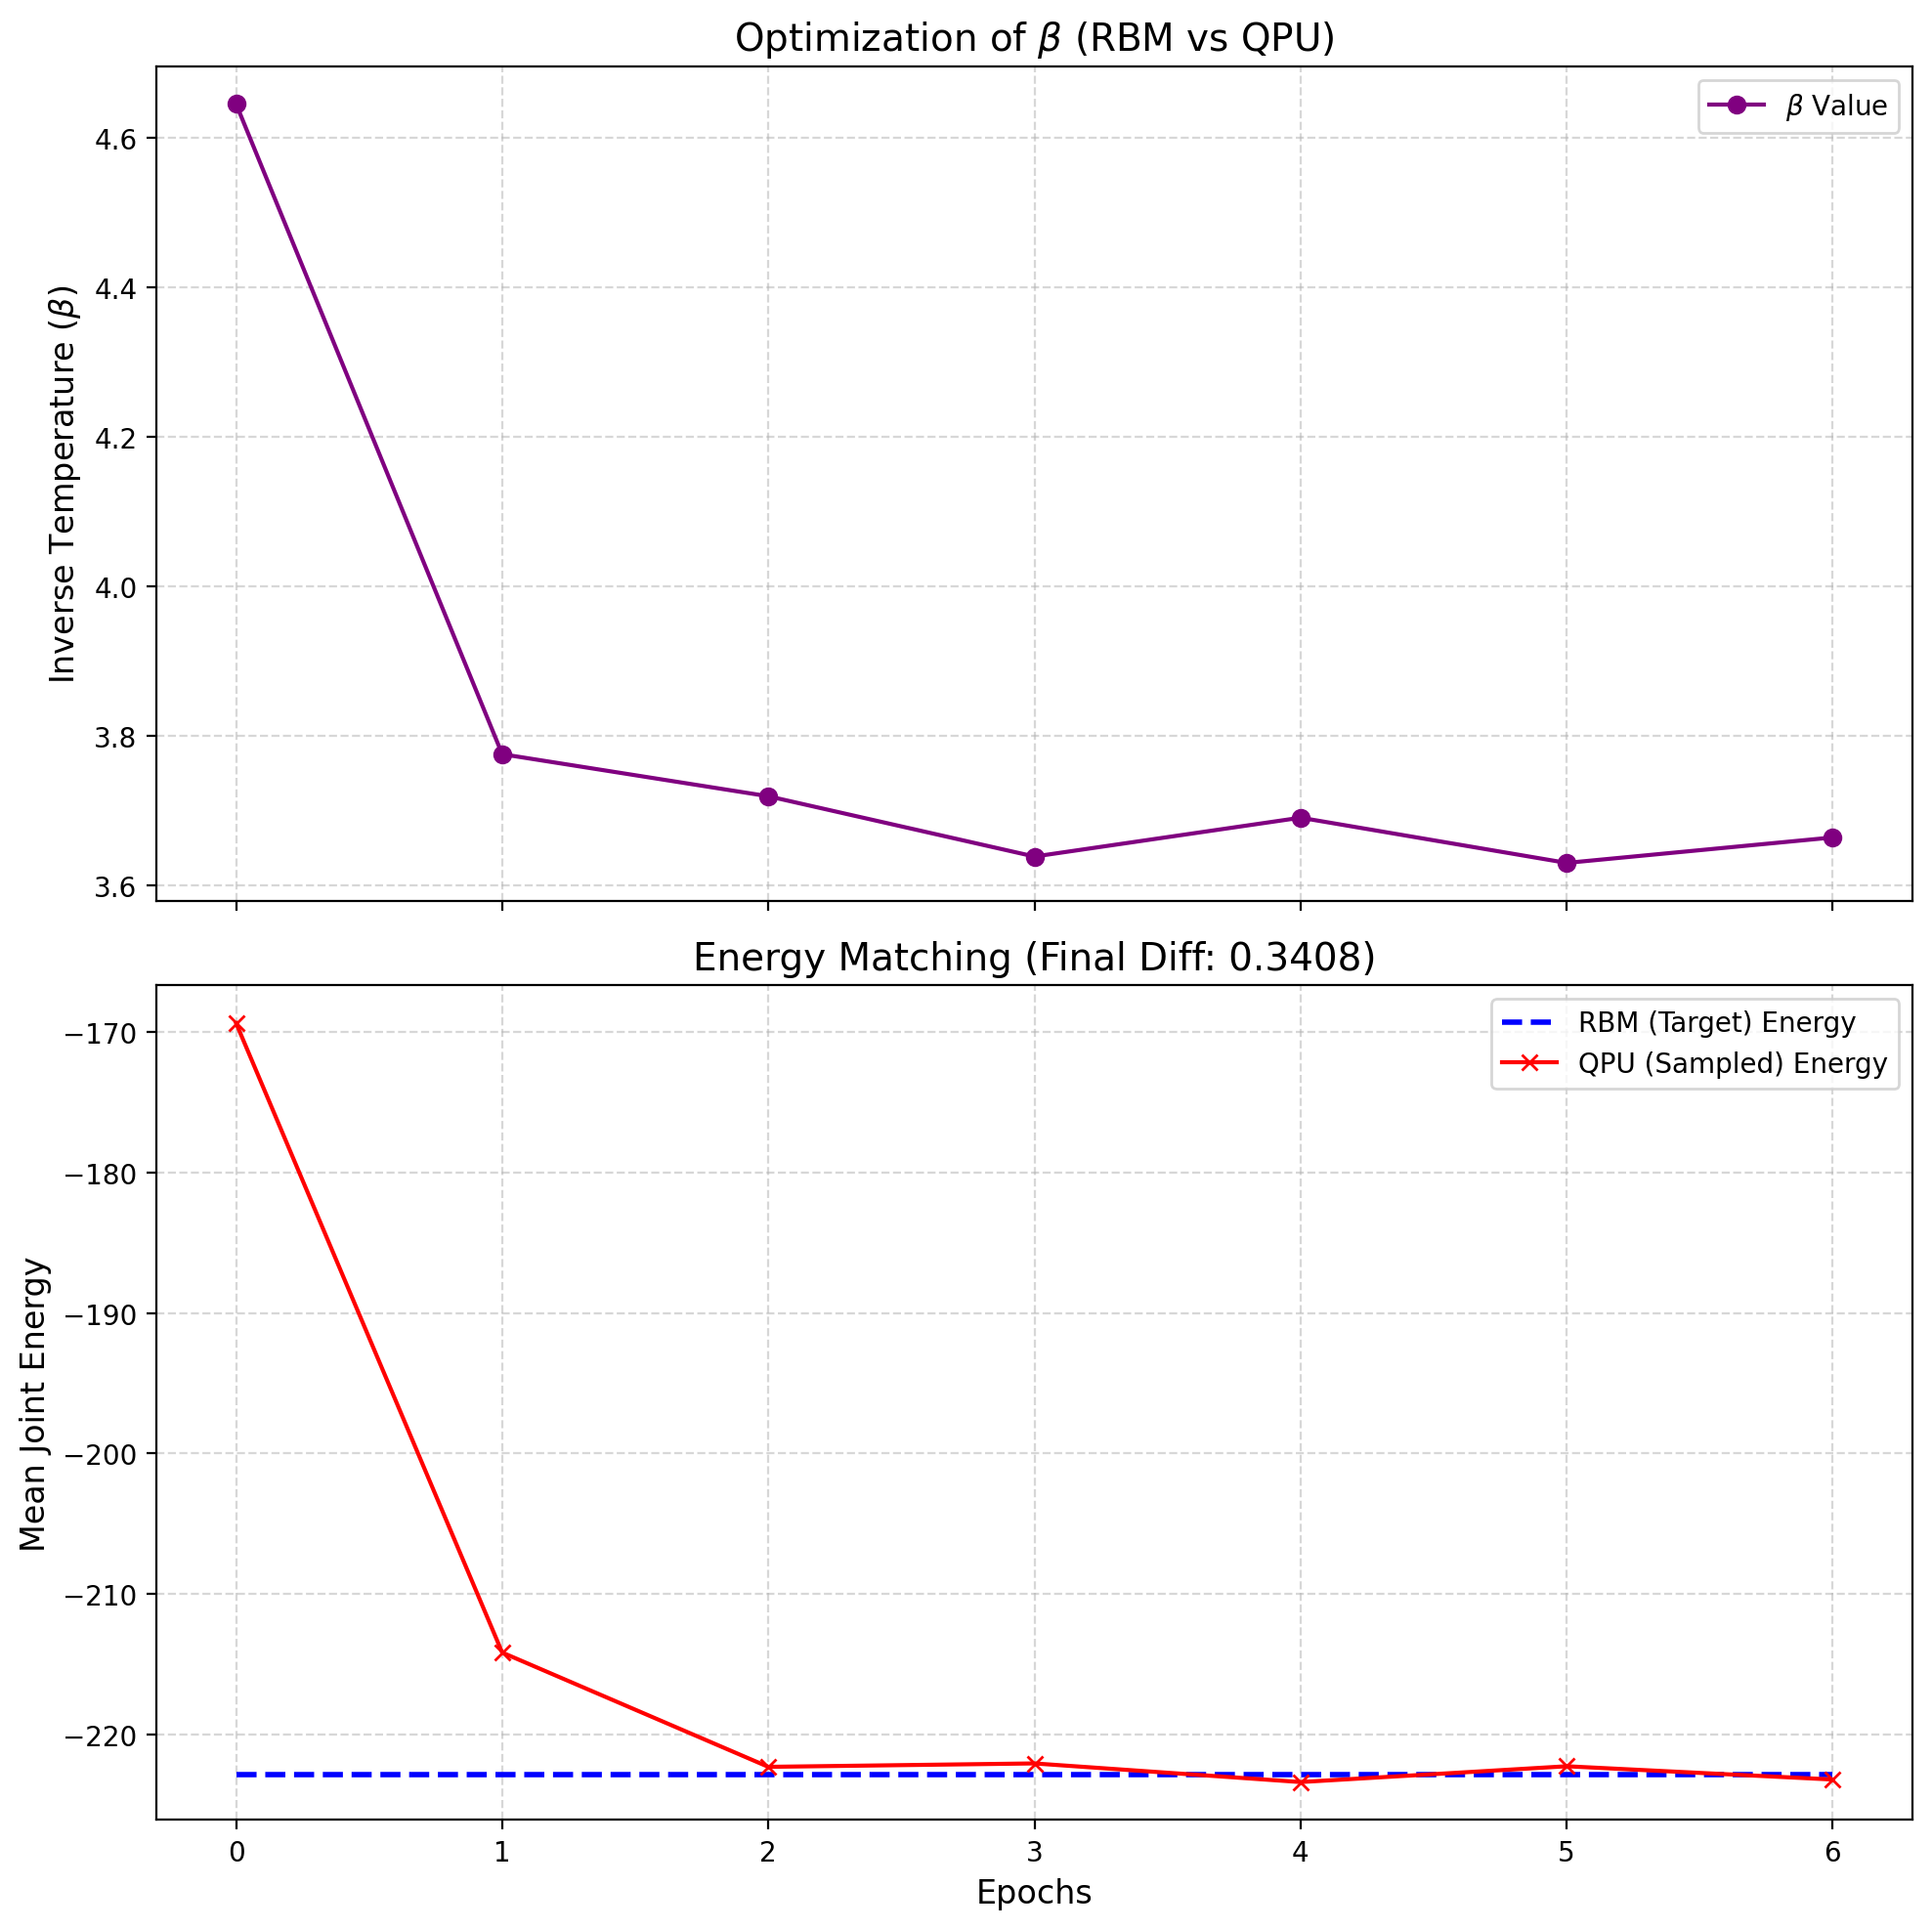

In [13]:
optimal_beta, beta_hist, rbm_e_hist, qpu_e_hist = find_beta(
    rbm, 
    qpu_sampler, 
    num_reads=128, 
    beta_init=10.0, 
    lr=0.1, 
    num_epochs=20 # Adjust based on your run
)

# 2. Setup the Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
epochs = np.arange(len(beta_hist))

# --- Plot 1: Beta Progression ---
ax1.plot(epochs, beta_hist, marker='o', linestyle='-', color='purple', label=r'$\beta$ Value')
ax1.set_ylabel(r'Inverse Temperature ($\beta$)', fontsize=12)
ax1.set_title(r'Optimization of $\beta$ (RBM vs QPU)', fontsize=14)
ax1.grid(True, which='both', linestyle='--', alpha=0.5)
ax1.legend()

# Annotate the final value
# ax1.annotate(f'Final $\\beta$: {optimal_beta:.4f}', 
#              xy=(epochs[-1], beta_hist[-1]), 
#              xytext=(epochs[-1]-2, beta_hist[-1]+(max(beta_hist)*0.1)),
#              arrowprops=dict(facecolor='black', shrink=0.05))

# --- Plot 2: Energy Comparison ---
ax2.plot(epochs, rbm_e_hist, label='RBM (Target) Energy', color='blue', linestyle='--', linewidth=2)
ax2.plot(epochs, qpu_e_hist, label='QPU (Sampled) Energy', color='red', marker='x', linestyle='-')

ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Mean Joint Energy', fontsize=12)
ax2.grid(True, which='both', linestyle='--', alpha=0.5)
ax2.legend()

# Highlight the convergence gap
final_diff = abs(qpu_e_hist[-1] - rbm_e_hist[-1])
ax2.set_title(f'Energy Matching (Final Diff: {final_diff:.4f})', fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
# sample at optimal beta
scaled_h, scaled_J, n_vis, n_hid = rbm_to_logical_ising(rbm, beta=optimal_beta)

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def plot_bias_dominance(rbm):
    """
    Visualizes the ratio between Biases and Weights to diagnose
    D-Wave scaling issues.
    """
    # 1. Extract Parameters (Move to CPU/Numpy)
    W = rbm.params["weight_matrix"].detach().cpu().numpy()
    vb = rbm.params["vbias"].detach().cpu().numpy()
    hb = rbm.params["hbias"].detach().cpu().numpy()

    # 2. Calculate "Interaction Strength" (Sum of absolute weights attached to node)
    # For Visible nodes: Sum over Hidden connections (axis 1)
    interaction_v = np.sum(np.abs(W), axis=1)
    # For Hidden nodes: Sum over Visible connections (axis 0)
    interaction_h = np.sum(np.abs(W), axis=0)

    # Safety epsilon to avoid division by zero
    eps = 1e-6

    # 3. Calculate Dominance Ratio (|Bias| / Sum(|Weights|))
    ratio_v = np.abs(vb) / (interaction_v + eps)
    ratio_h = np.abs(hb) / (interaction_h + eps)

    # 4. Create Plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=False)
    
    # --- Plot 1: Visible Layer Dominance ---
    # We reshape to (1, N) to plot as a heatmap strip
    im1 = ax1.imshow(ratio_v[np.newaxis, :], aspect='auto', cmap='magma', vmin=0, vmax=5)
    ax1.set_title(f'Visible Layer: Bias Dominance Ratio (|h| / $\sum|W|$)\n(Brighter = Bias is destroying couplings)', fontsize=14)
    ax1.set_yticks([])
    ax1.set_xlabel('Visible Node Index')
    cbar1 = plt.colorbar(im1, ax=ax1, orientation='vertical')
    cbar1.set_label('Ratio (>1 means Bias dominates)')

    # --- Plot 2: Hidden Layer Dominance ---
    im2 = ax2.imshow(ratio_h[np.newaxis, :], aspect='auto', cmap='magma', vmin=0, vmax=5)
    ax2.set_title(f'Hidden Layer: Bias Dominance Ratio', fontsize=14)
    ax2.set_yticks([])
    ax2.set_xlabel('Hidden Node Index')
    cbar2 = plt.colorbar(im2, ax=ax2, orientation='vertical')
    cbar2.set_label('Ratio')

    plt.tight_layout()
    plt.show()

    # --- 5. Statistical Summary ---
    print(f"--- Diagnostics ---")
    print(f"Visible Bias Range: [{np.min(vb):.2f}, {np.max(vb):.2f}]")
    print(f"Visible Interaction Range: [{np.min(interaction_v):.2f}, {np.max(interaction_v):.2f}]")
    print(f"Max Visible Ratio: {np.max(ratio_v):.2f}")
    
    # The "Squish" Factor
    # If we scale the max bias to 2.0, what does the average weight become?
    max_abs_bias = max(np.max(np.abs(vb)), np.max(np.abs(hb)))
    avg_abs_weight = np.mean(np.abs(W))
    
    scale_factor = 2.0 / max_abs_bias
    scaled_avg_weight = avg_abs_weight * scale_factor
    
    print(f"\n--- The 'Squish' Check ---")
    print(f"Max Absolute Bias in System: {max_abs_bias:.2f}")
    print(f"Average Weight Magnitude: {avg_abs_weight:.4f}")
    print(f"If D-Wave scales Max Bias to 2.0...")
    print(f"...the Average Weight becomes: {scaled_avg_weight:.5f}")
    
    if scaled_avg_weight < 0.05:
        print("\n[CRITICAL WARNING] The scaled weight is below the D-Wave noise floor (~0.05).")
        print("The QPU cannot 'see' your weights because the biases are too loud.")
    else:
        print("\n[OK] The scaled weights should be visible to the QPU.")

# Run the function
plot_bias_dominance(rbm)

In [ ]:
"""
    This was taken from https://github.com/dwavesystems/dwave-system/pull/513/files#diff-9a532ba673abaa03a87ac2a1c71e0f57f84e6eff24c6e7081a2fe23f4f5e6f43R443
    A simple use case: Consider three spins
    
    h = {0: 0.0, 1: 0., 2: -3.5}
    J = {(0, 1): 1, (1, 2): 1}
    embedding = {0: [30], 1: [45], 2: [2985]}
    fb = [0]*qpu.properties['num_qubits']    
    sampleset = FixedEmbeddingComposite(qpu, embedding).sample_ising(h, J,
                   num_reads=100, flux_drift_compensation=False, flux_biases=fb)       
    sampleset.record["sample"]
    >> [[-1,1,1],
        [1,-1,1]]
        
    Since spin 2985 has a self-field -3.5 which minimizes energy when it's 1
    
    Now, we do:
    
    fb[2985] = h_to_fluxbias(20)
    sampleset = FixedEmbeddingComposite(qpu, embedding).sample_ising(h, J,
                   num_reads=100, flux_drift_compensation=False, flux_biases=fb)       
    sampleset.record["sample"]
    >> [[-1,1,-1]]
    
    For our purposes, suppose spin 60 needs to be up and spin 61 down. then we do:
    
    fb[60] = h_to_fluxbias(-20)  
    fb[61] = h_to_fluxbias(20)    # I was able to go up to 50, but ~20 should be enough
    response = self._qpu_sampler.sample_ising(h, J, num_reads=num_samples, answer_mode='raw', auto_scale=False, flux_drift_compensation=False, flux_biases=fb)
"""

from typing import Optional, Literal, Union
import numpy as np


def h_to_fluxbias(h: Union[float, np.ndarray]=1,
                  Ip: Optional[float]=None,
                  B: float=1.391, MAFM: Optional[float]=1.647,
                  units_Ip: Optional[str]='uA',
                  units_B : str='GHz',
                  units_MAFM : Optional[str]='pH') -> Union[float, np.ndarray]:
    """Convert problem Hamiltonian bias ``h`` to equivalent flux bias.
    Unitless bias ``h`` is converted to the equivalent flux bias in units 
    :math:`\Phi_0`, the magnetic flux quantum.
    The dynamics of ``h`` and flux bias differ, as described in the
    :func:`Ip_in_units_of_B` function.
    Equivalence at a specific point in the anneal is valid under a 
    freeze-out (quasi-static) hypothesis.
    Defaults are based on the published physical properties of 
    `Leap <https://cloud.dwavesys.com/leap/>`_\ 's  
    ``Advantage_system4.1`` solver at single-qubit freezeout (:math:`s=0.612`).
    Args:
        Ip:
            Persistent current, :math:`I_p(s)`, in units of amps or 
            microamps. When not provided, inferred from :math:`M_{AFM}` 
            and and :math:`B(s)` based on the relation 
            :math:`B(s) = 2 M_{AFM} I_p(s)^2`. 
    
        B:
            Annealing schedule field, :math:`B(s)`, associated with the 
            problem Hamiltonian. Schedules are provided for each quantum 
            computer in the 
            :ref:`system documentation <sysdocs_gettingstarted:doc_qpu_characteristics>`. 
            This parameter is ignored when ``Ip`` is specified.
        
        MAFM:
            Mutual inductance, :math:`M_{AFM}`, specified for each quantum 
            computer in the 
            :ref:`system documentation <sysdocs_gettingstarted:doc_qpu_characteristics>`. 
            ``MAFM`` is ignored when ``Ip`` is specified.
        units_Ip:
            Units in which the persistent current, ``Ip``, is specified. 
            Allowed values are ``'uA'`` (microamps) and ``'A'`` (amps)
        units_B:
            Units in which the schedule ``B`` is specified. Allowed values
            are ``'GHz'`` (gigahertz) and ``'J'`` (Joules).
        units_MAFM:
            Units in which the mutual inductance, ``MAFM``, is specified. Allowed 
            values are ``'pH'`` (picohenry) and ``'H'`` (Henry).
    
    Returns:
        Flux-bias values producing equivalent longitudinal fields to the given 
        ``h`` values.
    """
    Ip = Ip_in_units_of_B(Ip, B, MAFM,
                          units_Ip, units_B, units_MAFM)  # Convert/Create Ip in units of B, scalar
    # B(s)/2 h_i = Ip(s) phi_i 
    # print(B, Ip, h)
    return -B/2/Ip*h



def Ip_in_units_of_B(Ip: Union[None, float, np.ndarray]=None,
                     B: Union[None, float, np.ndarray]=1.391,
                     MAFM: Optional[float]=1.647,
                     units_Ip: Optional[str]='uA',
                     units_B: Literal['GHz', 'J'] = 'GHz',
                     units_MAFM : Optional[str]='pH') -> Union[float, np.ndarray]:
    """Estimate qubit persistent current :math:`I_p(s)` in schedule units. 
    Under a simple, noiseless freeze-out model, you can substitute flux biases 
    for programmed linear biases, ``h``, in the standard transverse-field Ising 
    model as implemented on D-Wave quantum computers. Perturbations in ``h`` are 
    not, however, equivalent to flux perturbations with respect to dynamics 
    because of differences in the dependence on the anneal fraction, :math:`s`: 
    :math:`I_p(s) \propto \sqrt(B(s))`. The physical origin of each term is different, 
    and so precision and noise models also differ.
    
    Assume a Hamiltonian in the :ref:`documented form <sysdocs_gettingstarted:doc_qpu>` 
    with an additional flux-bias-dependent component 
    :math:`H(s) \Rightarrow H(s) - H_F(s) \sum_i \Phi_i \sigma^z_i`,
    where :math:`\Phi_i` are flux biases (in units of :math:`\Phi_0`), 
    :math:`\sigma^z_i` is the Pauli-z operator, and 
    :math:`H_F(s) = Ip(s) \Phi_0`. Schedules for D-Wave quantum computers 
    specify energy in units of Joule or GHz. 
    Args:
        Ip:
            Persistent current, :math:`I_p(s)`, in units of amps or 
            microamps. When not provided, inferred from :math:`M_{AFM}` 
            and and :math:`B(s)` based on the relation 
            :math:`B(s) = 2 M_{AFM} I_p(s)^2`. 
    
        B:
            Annealing schedule field, :math:`B(s)`, associated with the 
            problem Hamiltonian. Schedules are provided for each quantum 
            computer in the 
            :ref:`system documentation <sysdocs_gettingstarted:doc_qpu_characteristics>`. 
            This parameter is ignored when ``Ip`` is specified.
        
        MAFM:
            Mutual inductance, :math:`M_{AFM}`, specified for each quantum 
            computer in the 
            :ref:`system documentation <sysdocs_gettingstarted:doc_qpu_characteristics>`. 
            ``MAFM`` is ignored when ``Ip`` is specified.
        units_Ip:
            Units in which the persistent current, ``Ip``, is specified. 
            Allowed values are ``'uA'`` (microamps) and ``'A'`` (amps)
        units_B:
            Units in which the schedule ``B`` is specified. Allowed values
            are ``'GHz'`` (gigahertz) and ``'J'`` (Joules).
        units_MAFM:
            Units in which the mutual inductance, ``MAFM``, is specified. Allowed 
            values are ``'pH'`` (picohenry) and ``'H'`` (Henry).
    
    Returns:
        :math:`I_p(s)` with units matching the Hamiltonian :math:`B(s)`.
    """
    h = 6.62607e-34  # Plank's constant for converting energy in Hertz to Joules 
    Phi0 = 2.0678e-15  # superconducting magnetic flux quantum (h/2e); units: Weber=J/A

    if units_B == 'GHz':
        B_multiplier = 1e9*h  # D-Wave schedules use GHz by convention
    elif units_B == 'J':
        B_multiplier = 1
    else:
        raise ValueError('Schedule B must be in units GHz or J, ' 
                         f'but given {units_B}')
    if Ip is None:
        B = B*B_multiplier # To Joules
        if units_MAFM == 'pH':
            MAFM = MAFM*1e-12  # conversion from picohenry to Henry
        elif units_MAFM != 'H':
            raise ValueError('MAFM must be in units pH or H, ' 
                             f'but given {units_MAFM}')
        Ip = np.sqrt(B/(2*MAFM))  # Units of A = C/s, O(1e-6) 
    else:
        if units_Ip == 'uA':
            Ip = Ip*1e-6  # Conversion from microamps to amp
        elif units_Ip != 'A':
            raise ValueError('Ip must be in units uA or A, ' 
                             f'but given {units_Ip}')

    return Ip*Phi0/B_multiplier

    
def get_physical_flux_biases(
    embedding: Dict[int, List[int]],
    total_physical_qubits: int,
    logical_clamps: Dict[int, float],
    clamp_strength_h: float = 30.0
) -> List[float]:
    """
    Generates the physical flux bias list required by the D-Wave QPU.
    
    Args:
        embedding: Dict mapping logical_idx -> list of physical_qubits.
        total_physical_qubits: Total number of qubits on the actual chip 
                               (e.g., sampler.properties['num_qubits']).
        logical_clamps: Dict {logical_node_idx: direction}, where direction is +1 or -1.
                        These are the nodes you want to fix.
        clamp_strength_h: The magnitude of the clamp in 'h' units before conversion 
                          to flux bias units.
    
    Returns:
        List[float]: A list of zeros with specific indices set to the flux bias value.
                     Length equals the total number of physical qubits on the chip.
    """
    # 1. Initialize bias list for the entire QPU (not just the active graph)
    # D-Wave requires this list to match the hardware size exactly.
    physical_flux_biases = [0.0] * total_physical_qubits
    
    # 2. Iterate through the Logical Nodes we want to clamp
    for logical_node, direction in logical_clamps.items():
        
        if logical_node not in embedding:
            # This assumes the embedding covers all nodes, which it should.
            print(f"Warning: Logical node {logical_node} not found in embedding. Skipping.")
            continue
            
        # 3. Retrieve the Chain (List of physical qubits)
        chain = embedding[logical_node]
        
        # 4. Calculate Bias Value
        # We apply the SAME bias to every qubit in the chain to reinforce the state.
        # Logic: (Sign) * (Magnitude)
        h_val = direction * clamp_strength_h 
        fb_val = h_to_fluxbias(h_val)
        
        # 5. Apply to all physical qubits in the chain
        for physical_qubit_idx in chain:
            # Sanity check bounds
            if physical_qubit_idx < total_physical_qubits:
                physical_flux_biases[physical_qubit_idx] += fb_val
            else:
                print(f"Error: Physical index {physical_qubit_idx} out of bounds.")

    return physical_flux_biases

def run_precalculated_clamping(
    qpu_sampler,
    embedding,
    h, J,
    binary_patterns_batch, 
    logical_idx_map,       
    clamp_strength=20.0 # User requests 20.0
):
    # --- 1. Determine Safe Limits ---
    # Standard Advantage limit is usually approx 0.11 Phi_0. 
    # We use 0.1 to be conservative and avoid "SolverFailureError".
    SAFE_FLUX_LIMIT = 0.01 
    
    # Calculate how much flux your specific h_to_fluxbias function produces per unit h
    # This depends on the defaults in your function (Ip, B, MAFM)
    flux_conversion_rate = abs(h_to_fluxbias(1.0))
    
    # Calculate the Max h that fits in the flux limit
    max_possible_h = SAFE_FLUX_LIMIT / flux_conversion_rate
    
    # Determine the effective clamp strength
    if clamp_strength > max_possible_h:
        print(f"WARNING: Requested clamp_strength={clamp_strength:.2f} exceeds hardware limit.")
        print(f"         Auto-clipping to max safe h={max_possible_h:.4f} (which equals {SAFE_FLUX_LIMIT} Phi_0)")
        effective_clamp = max_possible_h
    else:
        effective_clamp = clamp_strength
        print(f"Clamp strength {effective_clamp:.2f} is within safety limits.")

    # --- 2. Standard Setup ---
    if hasattr(qpu_sampler, 'properties'):
        total_qubits = qpu_sampler.properties['num_qubits']
    elif hasattr(qpu_sampler, 'child'):
        total_qubits = qpu_sampler.child.properties['num_qubits']
    else:
        total_qubits = 6000 

    composite_sampler = FixedEmbeddingComposite(qpu_sampler, embedding)
    all_responses = []
    
    print(f"--- Processing {len(binary_patterns_batch)} patterns ---")
    
    # --- 3. Loop ---
    for i, row in enumerate(binary_patterns_batch):
        if isinstance(row, torch.Tensor):
            row = row.detach().cpu().numpy()
            
        logical_clamps = {}
        for bit_idx, bit_val in enumerate(row):
            target_node = logical_idx_map[bit_idx]
            spin = 1 if bit_val > 0.5 else -1
            logical_clamps[target_node] = spin
            
        # Use the SAFE effective_clamp here
        fb_list = get_physical_flux_biases(
            embedding=embedding,
            total_physical_qubits=total_qubits,
            logical_clamps=logical_clamps,
            clamp_strength_h=effective_clamp 
        )
        
        # Sanity Check for the very first sample
        if i == 0:
            max_fb_applied = max(abs(x) for x in fb_list)
            print(f"Sample 0 Check: Max Applied Flux Bias = {max_fb_applied:.6f} Phi_0")
            if max_fb_applied > 0.12: # 0.12 is usually the absolute hard ceiling
                 print("DANGER: Flux bias might still be too high for some QPUs.")

        response = composite_sampler.sample_ising(
            h, J,
            num_reads=1,
            answer_mode='raw',
            auto_scale=False,
            flux_biases=fb_list,
            chain_strength=1.5, 
            flux_drift_compensation=False
        )
        all_responses.append(response)
        
        if i % 20 == 0:
            print(f"Sampled {i}/{len(binary_patterns_batch)}")
            
    return all_responses

In [ ]:
wandb.init(tags = [cfg.data.dataset_name], project=cfg.wandb.project, entity=cfg.wandb.entity, config=OmegaConf.to_container(cfg, resolve=True), mode='disabled')
self.evaluate_ae(self.data_mgr.val_loader, epoch=0)

In [ ]:
incidence_energies = self.incident_energy[:NUM_SAMPLES]
num_clamped_bits = 19
bin_energy = self.model.encoder.binary_energy_refactored(incidence_energies)[:, :num_clamped_bits]
logical_idx_map = list(range(num_clamped_bits))


In [ ]:

results = run_precalculated_clamping(
    qpu_sampler=raw_sampler, # The raw sampler (not embedding composite)
    embedding=embedding,
    h=h_logical, 
    J=J_logical,
    binary_patterns_batch=bin_energy,
    logical_idx_map=logical_idx_map,
    clamp_strength=30.0 # Adjust based on how hard you want to force them
)
visible_samples = []
for resp in results:
    v_s, h_s = process_rbm_samples(
        resp,
        n_vis,
        n_hid,
        rbm.device
    )
    visible_samples.append(v_s)
visible_samples = torch.cat(visible_samples, dim=0)
print(f"Clamped Visible Samples Shape: {visible_samples.shape}")

In [ ]:
def find_partial_conditioned_beta(
    rbm, 
    qpu_sampler,
    binary_patterns_batch: torch.Tensor, # Shape: [batch_size, n_clamped]
    logical_idx_map: List[int],          # Maps column i of batch -> logical node idx
    rbm_gibbs_steps: int = 1000,           # How many steps to let the RBM settle unclamped nodes
    beta_init: float = 1.0,
    lr: float = 0.1,
    num_epochs: int = 15,
    adaptive: bool = False,
    lr_cap: float = 0.5
):
    beta = beta_init
    beta_history = []
    rbm_energy_history = []
    qpu_energy_history = []

    n_clamped = binary_patterns_batch.shape[1]
    print(f"--- Starting Beta Optimization ---")
    print(f"Conditioning on {n_clamped} visible nodes. RBM will hallucinate the rest.")


    qpu_sampler, embedding = get_sampler_and_biclique_embedding(rbm.num_visible, rbm.num_hidden, qpu_sampler)

    composite_sampler = FixedEmbeddingComposite(qpu_sampler, embedding)
    if not composite_sampler:
        raise ValueError("Failed to create FixedEmbeddingComposite sampler.")

    # Hardware limits setup
    if hasattr(qpu_sampler, 'properties'):
        total_qubits = qpu_sampler.properties['num_qubits']


    # --- 1. Get RBM Baseline (Target) ---
    print("Calculating RBM Conditional Energy...")
    
    # Use the class method you provided to sample the unclamped nodes
    # This returns the FULL visible vector (clamped + sampled unclamped)
    # We use beta=1.0 for the baseline calculation as per standard RBM definition
    full_v_rbm = rbm.sample_v_given_v_clamped(
        clamped_v=binary_patterns_batch,
        n_clamped=n_clamped,
        gibbs_steps=rbm_gibbs_steps,
        beta=1.0 
    )
    
    # Now sample hiddens given this full visible state to get complete (v, h)
    # We use the helper _sample_h_given_v so we don't mess with internal chains
    full_h_rbm, _ = rbm._sample_h_given_v(full_v_rbm, beta=1.0)
    
    # Calculate Energy of the RBM's "dream"
    with torch.no_grad():
        e_rbm_batch = joint_energy(rbm, full_v_rbm, full_h_rbm)
        mean_rbm_energy = e_rbm_batch.mean().item()
        
    print(f"Target (RBM) Mean Energy: {mean_rbm_energy:.4f}")

    # --- 2. Optimization Loop ---
    for epoch in range(num_epochs):
        
        # A. Scale to Logical Ising
        scaled_h, scaled_J, n_vis, n_hid = rbm_to_logical_ising(rbm, beta=beta)
        
        # B. Zero out logical h for the clamped nodes
        # We rely on Flux Bias for these; removing logical h prevents interference.
        for node_idx in logical_idx_map:
            if node_idx in scaled_h:
                scaled_h[node_idx] = 0.0
        
        # Heuristic chain strength
        max_abs_j = max([abs(val) for val in scaled_J.values()])
        chain_str = max(0.5, max_abs_j * 2.0) 
        
        # C. Sample Conditioned QPU
        qpu_v_list = []
        qpu_h_list = []
        
        # Iterate through the batch
        for i, row in enumerate(binary_patterns_batch):
            
            row_np = row.detach().cpu().numpy()
            logical_clamps = {}
            
            # Map the partial input to logical nodes
            for bit_idx, bit_val in enumerate(row_np):
                target_node = logical_idx_map[bit_idx]
                spin = 1 if bit_val > 0.5 else -1
                logical_clamps[target_node] = spin
            
            # Generate Flux Biases for the clamped nodes
            fb_list = get_physical_flux_biases(
                embedding=embedding,
                total_physical_qubits=total_qubits,
                logical_clamps=logical_clamps,
                clamp_strength_h=30.0 # You can adjust this value
            )
            
            # Submit to QPU
            # The QPU will fix the clamped nodes and anneal the rest (unclamped + hiddens)
            response = composite_sampler.sample_ising(
                scaled_h, scaled_J,
                num_reads=1, 
                answer_mode='raw',
                auto_scale=False,
                flux_biases=fb_list,
                chain_strength=chain_str,
                flux_drift_compensation=False
            )
            
            # Process returns the FULL visible and hidden vectors
            v_s, h_s = process_rbm_samples(response, n_vis, n_hid, rbm.device)
            qpu_v_list.append(v_s)
            qpu_h_list.append(h_s)
            if i % 20 == 0:
                print(f" Sampled {i}/{len(binary_patterns_batch)} patterns.")
        
        # D. Concatenate & Compute Energy
        dwave_v = torch.cat(qpu_v_list, dim=0)
        dwave_h = torch.cat(qpu_h_list, dim=0)
        
        with torch.no_grad():
            # Calculate energy using the RBM's weights (at beta=1.0 scale)
            # This tells us "How likely is this QPU sample according to the RBM?"
            e_dwave_batch = joint_energy(rbm, dwave_v, dwave_h)
            mean_dwave_energy = e_dwave_batch.mean().item()
            var_dwave_energy = torch.var(e_dwave_batch).item()

        # E. Update Beta
        if adaptive:
            safe_var = max(1e-6, var_dwave_energy)
            calc_lr = (beta**2) / safe_var
            current_lr = min(lr_cap, max(lr, calc_lr))
        else:
            current_lr = lr

        diff = mean_dwave_energy - mean_rbm_energy
        beta += current_lr * diff
        beta = max(1e-2, beta)

        beta_history.append(beta)
        rbm_energy_history.append(mean_rbm_energy)
        qpu_energy_history.append(mean_dwave_energy)
        
        print(f"Epoch {epoch}: Beta={beta:.4f} | QPU_E={mean_dwave_energy:.2f} vs RBM_E={mean_rbm_energy:.2f} | Diff={diff:.2f}")
        
        if abs(diff) < 0.5: 
            print("Converged.")
            break
            
    return beta, beta_history, rbm_energy_history, qpu_energy_history

In [ ]:
optimal_beta, beta_hist, rbm_e_hist, qpu_e_hist = find_partial_conditioned_beta(
    rbm, 
    SOLVER_NAME, 
    logical_idx_map=logical_idx_map,
    binary_patterns_batch=bin_energy,
    beta_init=10.0, 
    lr=0.1, 
    num_epochs=2 # Adjust based on your run
)

# 2. Setup the Plot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
epochs = np.arange(len(beta_hist))

# --- Plot 1: Beta Progression ---
ax1.plot(epochs, beta_hist, marker='o', linestyle='-', color='purple', label=r'$\beta$ Value')
ax1.set_ylabel(r'Inverse Temperature ($\beta$)', fontsize=12)
ax1.set_title(r'Optimization of $\beta$ (RBM vs QPU)', fontsize=14)
ax1.grid(True, which='both', linestyle='--', alpha=0.5)
ax1.legend()

# Annotate the final value
# ax1.annotate(f'Final $\\beta$: {optimal_beta:.4f}', 
#              xy=(epochs[-1], beta_hist[-1]), 
#              xytext=(epochs[-1]-2, beta_hist[-1]+(max(beta_hist)*0.1)),
#              arrowprops=dict(facecolor='black', shrink=0.05))

# --- Plot 2: Energy Comparison ---
ax2.plot(epochs, rbm_e_hist, label='RBM (Target) Energy', color='blue', linestyle='--', linewidth=2)
ax2.plot(epochs, qpu_e_hist, label='QPU (Sampled) Energy', color='red', marker='x', linestyle='-')

ax2.set_xlabel('Epochs', fontsize=12)
ax2.set_ylabel('Mean Joint Energy', fontsize=12)
ax2.grid(True, which='both', linestyle='--', alpha=0.5)
ax2.legend()

# Highlight the convergence gap
final_diff = abs(qpu_e_hist[-1] - rbm_e_hist[-1])
ax2.set_title(f'Energy Matching (Final Diff: {final_diff:.4f})', fontsize=14)

plt.tight_layout()
plt.show()